# Climate Change: Earth Surface Temperatures

## Introduction
Using over 100 years of weather data, we will attempt to predict the average worldwide land and ocean temperature. We're going to pretend we don't have access to weather forecasts. We do, however, have access to a century's worth of historical global temperature averages, including global maximum and minimum temperatures, as well as global land and ocean temperatures. With all of this information, we may conclude that this is a supervised, regression machine learning problem.

This falls under the realm of supervised learning, given that we possess both the features and the target variable for prediction. The task takes on a regression nature because the target variable is continuous. In the training phase, multiple regression models are exposed to both features and targets, and they are tasked with learning how to effectively map the data to make predictions. Emphasizing the continuous nature of the target value further characterizes this as a regression task, setting it apart from classification tasks, where discrete classes are typically involved.

![Temperature Change](https://cff2.earth.com/uploads/2019/06/18173504/Harvard-scientist-We-have-5-years-to-mitigate-the-worst-of-climate-change-960x640.jpg)

Image Source: [Earth.com](https://www.earth.com/news/5-years-mitigate-climate-change/)

## Table of Contents
---
- [Introduction](#Introduction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Data Visualization](#Data-Visualization)
- [Model Preparation](#Model-Preparation)
- [Model Results](#Model-Results)
- [Discussion and recommendations](#Discussion-and-recommendations)

## Exploratory Data Analysis
Let's first import relevant libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble # RandomForestClassifier()
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn import neighbors

from statsmodels.tools.eval_measures import mse, rmse
from math import sqrt

# Read the full contents of the dataframes
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

Next, load the temperature data. We will be working with the [Berkeley Earth Climate Change: Earth Surface Temperature Dataset](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data) from Kaggle. This dataset contains Global Land and Ocean-and-Land Temperatures in a file named `GlobalTemperatures.csv`.

In [2]:
# Get data from global temperatures
temperature_df = pd.read_csv('GlobalTemperatures.csv')

# Look at shape of the dataframe
temperature_df.shape

(3192, 9)

In [3]:
temperature_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


We can see that there are 3192 records and 9 columns. Eight columns are numeric and represent continuous data while the `dt` column stores dates as objects in the form of `YYYY-MM-DD`. The column data is as follows:

>- `dt:` starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures
- `LandAverageTemperature:` global average land temperature in celsius
- `LandAverageTemperatureUncertainty:` the 95% confidence interval around the average
- `LandMaxTemperature:` global average maximum land temperature in celsius
- `LandMaxTemperatureUncertainty:` the 95% confidence interval around the maximum land temperature
- `LandMinTemperature:` global average minimum land temperature in celsius
- `LandMinTemperatureUncertainty:` the 95% confidence interval around the minimum land temperature
- `LandAndOceanAverageTemperature:` global average land and ocean temperature in celsius
- `LandAndOceanAverageTemperatureUncertainty:` the 95% confidence interval around the global average land and ocean temperature


To make things easier to interpet, we will create a function which converts the temperature from Celsius to Fahrenheit.

In [5]:
def convertTemptToFahrenheit(temp):
  tempInFahrenheit = (temp * 1.8) + 32
  return tempInFahrenheit

# Convert specific numerical columns from  Celsius to Fahrenheit
# temperature_df_numerical_features = temperature_df.select_dtypes(include='number') # we don't want to convert the uncertainty columns!
numerical_cols = ['LandAverageTemperature','LandMaxTemperature','LandMinTemperature','LandAndOceanAverageTemperature']
temperature_df[numerical_cols] = temperature_df[numerical_cols].apply(convertTemptToFahrenheit)

And we will convert the `dt` column to a DateTime object. We will only be concerned with temperature data for every individual year.


In [6]:
def converToDateTime(df):
  df = df.copy()
  df['dt'] = pd.to_datetime(df['dt'])
  df['Month'] = df['dt'].dt.month
  df['Year'] = df['dt'].dt.year
  return df

# Convert date to a DateTime object
new_temp_df = converToDateTime(temperature_df)
# Drop Date and Months
new_temp_df = new_temp_df.drop(['dt', 'Month'], axis=1)
# Set the index of the dataframe to Year
new_temp_df = new_temp_df.set_index('Year')
new_temp_df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Year,,,,,,,,
1750,37.4612,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750,37.5494,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750,42.1268,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750,47.2820,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750,52.8314,2.072,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

We will first examine all of the missing data.

In [7]:
new_temp_df.isnull().sum()

LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

We see that the columns `LandMaxTemperature`, `LandMaxTemperatureUncertainty`, `LandMinTemperature`, `LandMinTemperatureUncertainty`, `LandAndOceanAverageTemperature`, and `LandAndOceanAverageTemperatureUncertainty` all have 1200 missing records. This is because the data dictionary tells us that many of the numerical columns started receiving data around 1850. Lets verify this.

In [8]:
print("Land records start from:", new_temp_df[new_temp_df.LandAverageTemperature.notna()].index.min())
print("Ocean records start from:", new_temp_df[new_temp_df.LandAndOceanAverageTemperature.notna()].index.min())

Land records start from: 1750
Ocean records start from: 1850


We should therefore only accept records past 1850.

In [9]:
temp_df_cleaned = new_temp_df[new_temp_df.index >=1850]
temp_df_cleaned.isnull().sum()

LandAverageTemperature                       0
LandAverageTemperatureUncertainty            0
LandMaxTemperature                           0
LandMaxTemperatureUncertainty                0
LandMinTemperature                           0
LandMinTemperatureUncertainty                0
LandAndOceanAverageTemperature               0
LandAndOceanAverageTemperatureUncertainty    0
dtype: int64

In [10]:
temp_df_cleaned.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Year,,,,,,,,
1850,33.3482,1.105,46.8356,1.738,26.2292,2.822,55.0994,0.367
1850,37.5278,1.275,49.9460,3.007,27.8762,1.623,56.4584,0.414
1850,40.9172,0.955,50.6246,2.401,28.5710,1.410,57.2774,0.341
1850,44.9906,0.665,55.2812,1.004,33.8324,1.329,58.4006,0.267
1850,50.0072,0.617,60.1790,2.406,38.8598,1.347,59.9126,0.249


In [11]:
temp_df_cleaned.shape

(1992, 8)

We can now see that we have cleaned the missing data and that we now have 1908 records for the eight numerical columns.

## Data Visualization

We will now use the existing temperature data to visualize the average temperature every year. Lets create a line plot of the land data and then the combined land and ocean data.

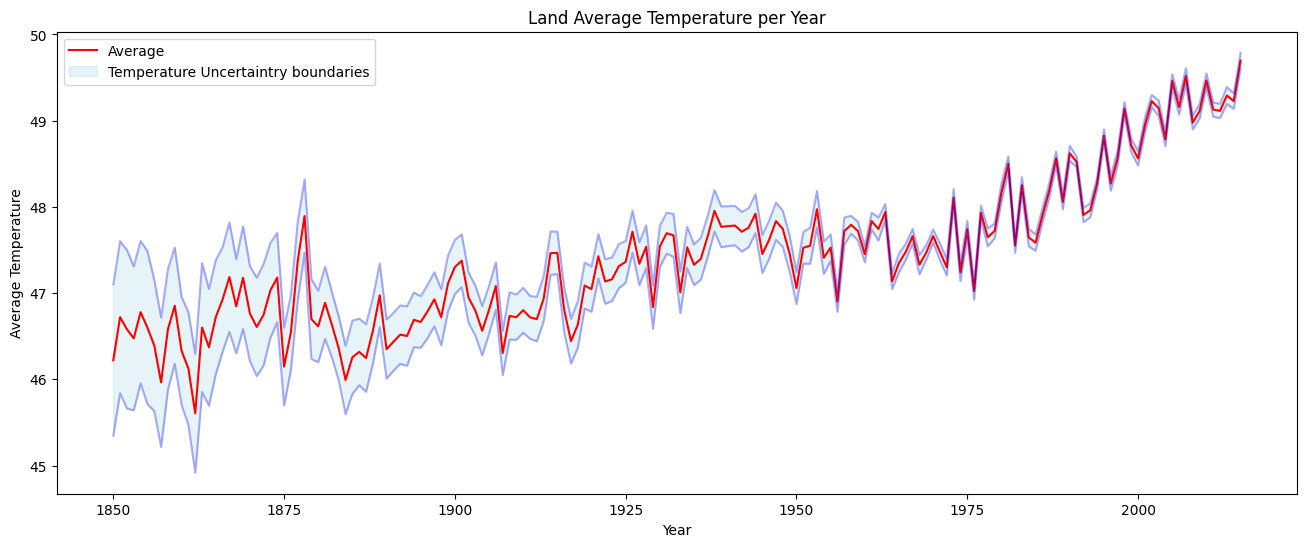

In [12]:
def plot_average_temp(df,col1,col2,label):
  cols = [col1,col2]
  temp_df = df[cols]
  average_per_year = temp_df.groupby(temp_df.index)[cols].mean()
  average_per_year['lower temp'] = average_per_year[col1] - average_per_year[col2]
  average_per_year['upper temp'] = average_per_year[col1] + average_per_year[col2]

  plt.figure(figsize=(16,6))
  plt.plot(average_per_year.index, average_per_year[col1], color='red', label='Average')
  plt.plot(average_per_year.index, average_per_year['upper temp'], color='blue', alpha=0.3)
  plt.plot(average_per_year.index, average_per_year['lower temp'], color='blue', alpha=0.3)
  plt.fill_between(average_per_year.index, average_per_year['upper temp'], average_per_year['lower temp'], color='lightblue', alpha=0.3, label='Temperature Uncertaintry boundaries')
  plt.xlabel('Year')
  plt.ylabel('Average Temperature')
  plt.title(label)
  plt.legend(loc='best')

# Land Average Temperature
plot_average_temp(temp_df_cleaned,'LandAverageTemperature','LandAverageTemperatureUncertainty','Land Average Temperature per Year')

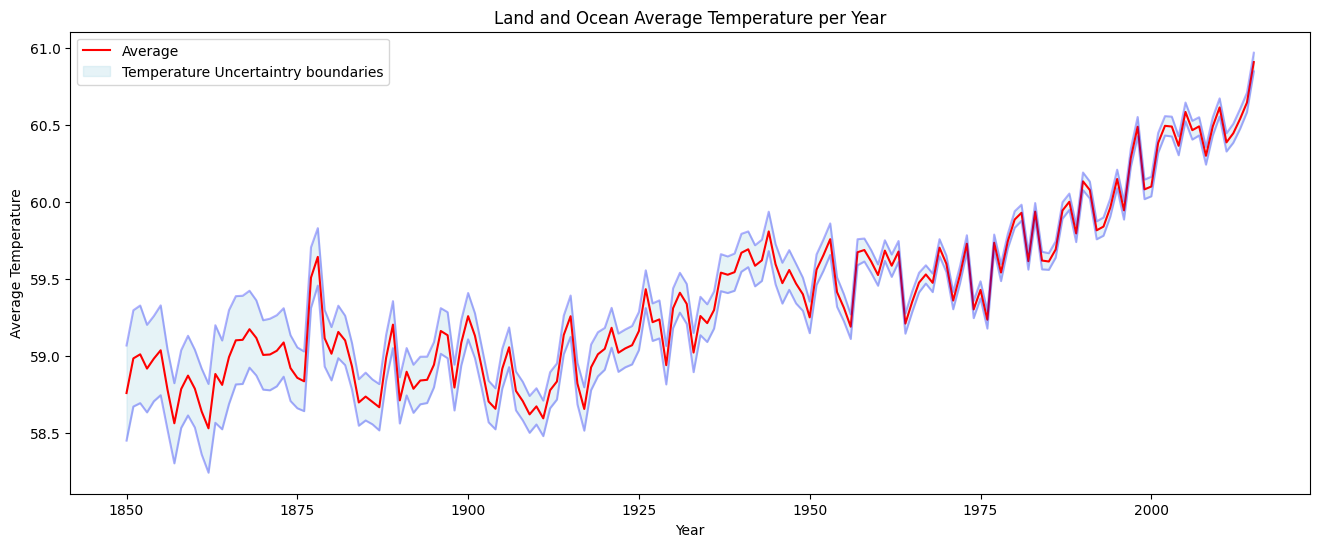

In [13]:
# Land and Ocean Average Temperature
plot_average_temp(temp_df_cleaned,'LandAndOceanAverageTemperature','LandAndOceanAverageTemperatureUncertainty','Land and Ocean Average Temperature per Year')

From these two plots, it is clear that the average temperature has increased by both land and sea from 1850 until now.

As we are working with a regression problem, it is a good idea to use a heatmap to visualize correlation between columns. We will look at the correlation between all numerical columns and the `LandAndOceanAverageTemperature` column (which will be the target variable in our machine learning models).

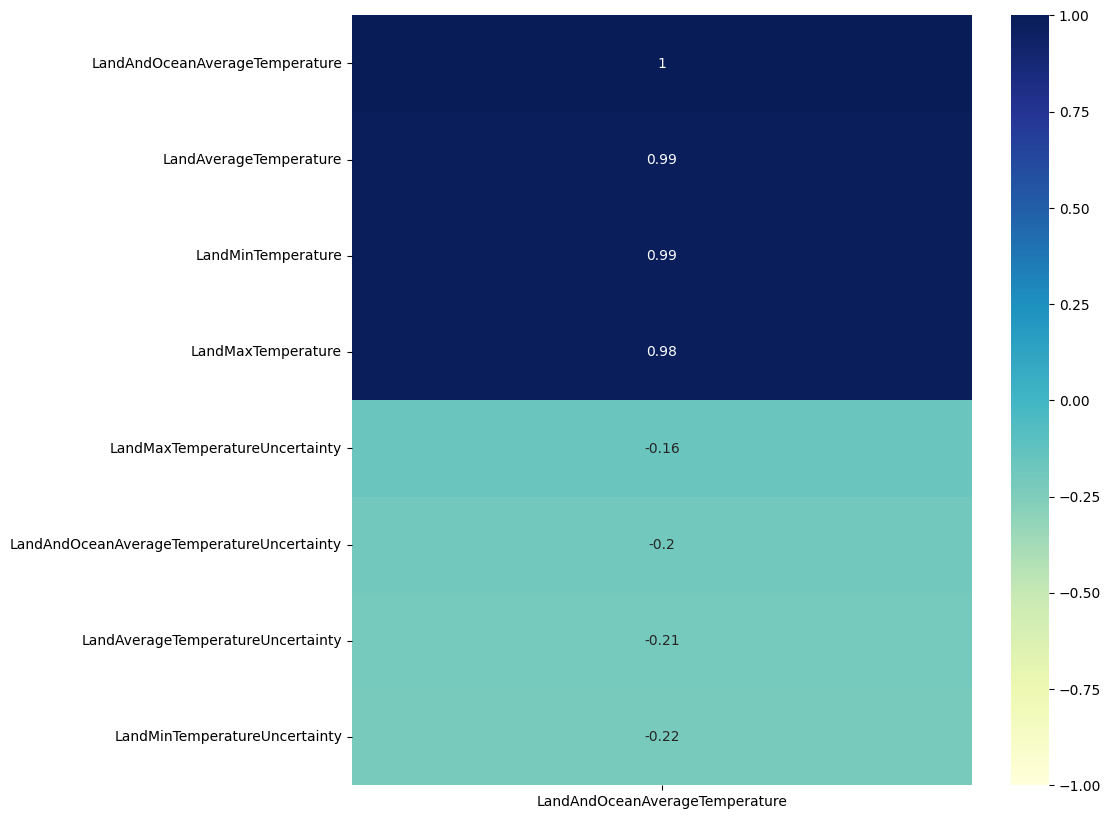

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
corr_matrix = np.abs(temp_df_cleaned.corr())
sns.heatmap(temp_df_cleaned.corr()[['LandAndOceanAverageTemperature']].sort_values('LandAndOceanAverageTemperature').tail(10),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

Here we see that highly correlated features are `LandAverageTemperature`, `LandMinTemperature`, and `LandMaxTemperature.` Features that are less correlated are `LandMaxTemperatureUncertainty`, `LandAndOceanAverageTemperatureUncertainty`, `LandAverageTemperatureUncertainty`, and `LandMinTemperatureUncertainty`. We will drop these columns.

In [15]:
def reduce_df(df):
  # Create a copy of the original dataframe
  df = df.copy()

  # Drop LandMaxTemperatureUncertainty, LandAndOceanAverageTemperatureUncertainty,
  # LandMinTemperatureUncertainty and LandMinTemperatureUncertainty
  cols_to_drop = ['LandMaxTemperatureUncertainty','LandAndOceanAverageTemperatureUncertainty',
                'LandAverageTemperatureUncertainty','LandMinTemperatureUncertainty']
  df = df.drop(cols_to_drop,axis=1)
  return df

reduced_temperature_df = reduce_df(temp_df_cleaned)

## Model Preparation

We will now separate our data into features and a target. We will choose the average land and ocean temperature as our target variable. The features will be the remaining three columns which we will use to predict the average land and ocean temperature.

In [16]:
# Features, X
X = reduced_temperature_df.drop('LandAndOceanAverageTemperature',axis=1)
# Target, Y
Y = reduced_temperature_df['LandAndOceanAverageTemperature']

Next, let's split our data into train and test and look at the shape of the resulting datasets.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=40)
print("Size of X_train: ", X_train.shape)
print("Size of X_test: ", X_test.shape)
print("Size of y_train: ", y_train.shape)
print("Size of y_test: ", y_test.shape)

Size of X_train:  (1494, 3)
Size of X_test:  (498, 3)
Size of y_train:  (1494,)
Size of y_test:  (498,)


Before we start building various machine learning models, we will look at a baseline model to see how well our models perform. Our baseline will be the yearly average temperature (i.e., what would occur if we used the average temperature in `Y_Train` to predict the temperature).

In [18]:
y_pred = [y_train.mean()] * len(y_train)

# MAE
print('Base MAE (in degrees):', round(mean_absolute_error(y_train,y_pred),2))

Base MAE (in degrees): 2.03


Thus, we see that our machine learning models must beat a baseline MAE of roughly 2 degrees.

## Model Results

We will look at a variety of standard supervised learning algorithms. First, we will create three helper functions.

In [19]:
# Capture k-fold output in a dataframe for comparisons
kfold_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])
kfold_mae_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

In [20]:
# Returns a dictionary of statistics to compare model accuracy provided that
# five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, scoring="explained_variance",cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
        print("Explained Variance:", ret_dict)
        return(ret_dict)
    else:
        print(cross_val_array)

In [21]:
# Returns a dictonary of statistics to compare model error provided that
# five folds are defined.
def kfold_xval_mae(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    # Minimizing MAE is equivalent to maximizing negative-MAE
    mae_val_array = cross_val_score(model, train_data, target_data, scoring="neg_mean_absolute_error", cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': mae_val_array[0],
                    'Fold_2': mae_val_array[1],
                    'Fold_3': mae_val_array[2],
                    'Fold_4': mae_val_array[3],
                    'Fold_5': mae_val_array[4],
                   }
        print("Negative Mean Absolute Error:", ret_dict)
        return(ret_dict)
    else:
        print(mae_val_array)

In [22]:
def comp_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

    # Make predictions
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    tips = sns.load_dataset("tips")
    ax = sns.regplot(data=tips,x=y_test,y=y_preds_test,scatter_kws={"color": "blue", 'alpha':0.3}, line_kws={"color": "red"})
    ax.set(xlabel='Test value', ylabel='Predicted value',title='Test values vs. predicted values,\n{}'.format(str(model)))
    plt.show()

    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

We will now test our model using several supervised learning algorithms including Linear Regression, KNN, Random Forest, Support Vector Machine, and Gradient Boosting. We also tested using Ridge Regression, Lasso Regression, and Elastic Net Regression (and omit these results as we get comparable results with Linear Regression).

#### Linear Regression

In [23]:
linear = LinearRegression()
cv_results = kfold_xval(linear,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'LinearRegression()', 'Fold_1': 0.9790021382761838, 'Fold_2': 0.9806291756390131, 'Fold_3': 0.9757299466116123, 'Fold_4': 0.9775378050166059, 'Fold_5': 0.9701140029742552}


In [24]:
mae_results = kfold_xval_mae(linear,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'LinearRegression()', 'Fold_1': -0.2680716464157339, 'Fold_2': -0.2581595143560645, 'Fold_3': -0.2915668637283162, 'Fold_4': -0.2903737711788681, 'Fold_5': -0.31607779226470484}


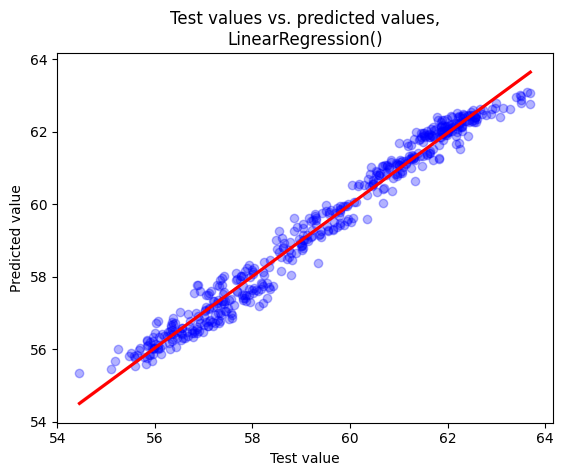

-----Test set statistics-----
R-squared of the model on the test set is: 0.9786110435505881
Mean absolute error of the prediction is: 0.2678993528424019
Mean squared error of the prediction is: 0.11143336885310137
Root mean squared error of the prediction is: 0.33381636995974506
Mean absolute percentage error of the prediction is: 0.45280798963265


In [25]:
comp_train_test(linear,X_train,y_train,X_test,y_test)

#### KNN

<Axes: title={'center': 'Elbow Curve from RMSE'}, xlabel='k', ylabel='RMSE'>

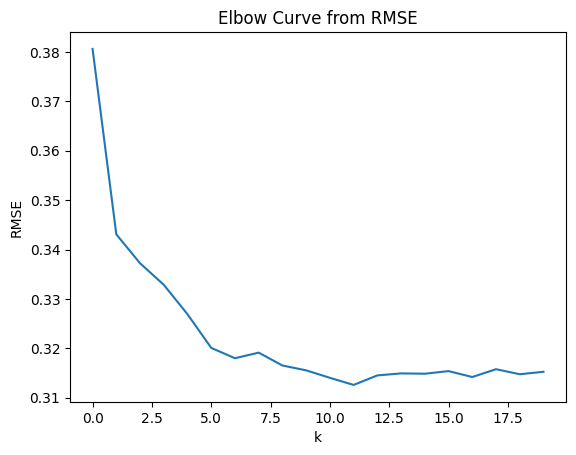

In [26]:
# Find the RMSE to plot an Elbow Curve
rmse_val = [] # Store RMSE values for different k
for k in range(20):
    k = k+1
    model = neighbors.KNeighborsRegressor(n_neighbors = k)

    model.fit(X_train, y_train)  # Tit the model
    pred=model.predict(X_test) # Make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) # Calculate RMSE
    rmse_val.append(error) # Store RMSE values

curve = pd.DataFrame(rmse_val) # Elbow curve
curve.plot(title="Elbow Curve from RMSE", xlabel="k", ylabel="RMSE", legend=None)

In [27]:
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 8) # By the Elbow curve above, we set k = 8
cv_results = kfold_xval(knn_model,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'KNeighborsRegressor(n_neighbors=8)', 'Fold_1': 0.9809384548066171, 'Fold_2': 0.9839072308429347, 'Fold_3': 0.9790453802746185, 'Fold_4': 0.9819610450484438, 'Fold_5': 0.9757135706086074}


In [28]:
mae_results = kfold_xval_mae(knn_model,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'KNeighborsRegressor(n_neighbors=8)', 'Fold_1': -0.25181187290969914, 'Fold_2': -0.22590526755852863, 'Fold_3': -0.2614003344481607, 'Fold_4': -0.24466831103678946, 'Fold_5': -0.2645282718120809}


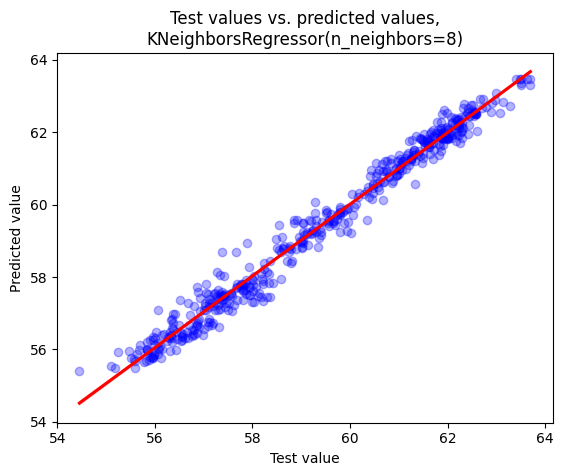

-----Test set statistics-----
R-squared of the model on the test set is: 0.9804517404190591
Mean absolute error of the prediction is: 0.23886099397590374
Mean squared error of the prediction is: 0.10184360445406632
Root mean squared error of the prediction is: 0.3191294478014624
Mean absolute percentage error of the prediction is: 0.40515812866611967


In [29]:
comp_train_test(knn_model,X_train,y_train,X_test,y_test)

#### Random Forest

In [30]:
rf_model = ensemble.RandomForestRegressor(n_estimators=10, n_jobs=-1)
cv_results = kfold_xval(rf_model,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'RandomForestRegressor(n_estimators=10, n_jobs=-1)', 'Fold_1': 0.977158141423021, 'Fold_2': 0.9823333827265501, 'Fold_3': 0.9794343815513059, 'Fold_4': 0.9800906738393405, 'Fold_5': 0.9752866053543385}


In [31]:
mae_results = kfold_xval_mae(rf_model,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'RandomForestRegressor(n_estimators=10, n_jobs=-1)', 'Fold_1': -0.27010595317725783, 'Fold_2': -0.2225504347826086, 'Fold_3': -0.25832167224080294, 'Fold_4': -0.2571935117056857, 'Fold_5': -0.2643004026845637}


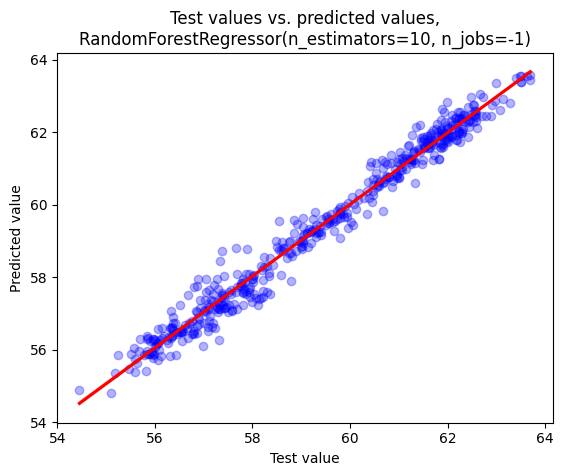

-----Test set statistics-----
R-squared of the model on the test set is: 0.9783081508333805
Mean absolute error of the prediction is: 0.24884024096385574
Mean squared error of the prediction is: 0.11301139609156659
Root mean squared error of the prediction is: 0.3361716765159828
Mean absolute percentage error of the prediction is: 0.4213421252121048


In [32]:
comp_train_test(rf_model,X_train,y_train,X_test,y_test)

#### Support Vector Machine

In [33]:
svm_model = SVR(kernel = 'rbf')
cv_results = kfold_xval(svm_model,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'SVR()', 'Fold_1': 0.9796499524935859, 'Fold_2': 0.9814053019765446, 'Fold_3': 0.9759924440122779, 'Fold_4': 0.9780082669633328, 'Fold_5': 0.9715311224630794}


In [34]:
mae_results = kfold_xval_mae(svm_model,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'SVR()', 'Fold_1': -0.26107237293172747, 'Fold_2': -0.2481340686191278, 'Fold_3': -0.2817306640246269, 'Fold_4': -0.286146139945242, 'Fold_5': -0.3077658101932516}


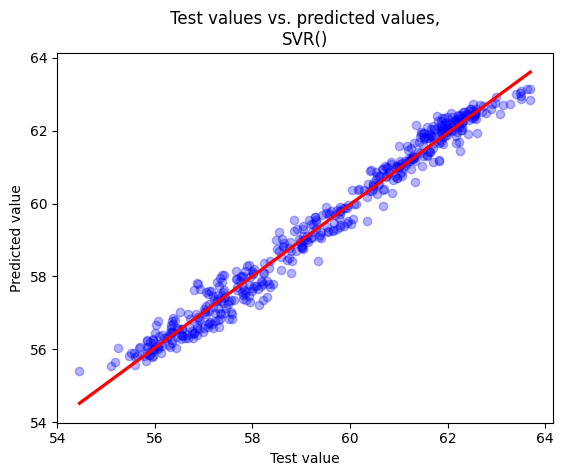

-----Test set statistics-----
R-squared of the model on the test set is: 0.9793654650881497
Mean absolute error of the prediction is: 0.2582612535618929
Mean squared error of the prediction is: 0.10750294178132494
Root mean squared error of the prediction is: 0.32787641235887177
Mean absolute percentage error of the prediction is: 0.43687139827629135


In [35]:
comp_train_test(svm_model,X_train,y_train,X_test,y_test)

#### Gradient Boosting

Before computing scores, we will first use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the optimal parameters.

In [36]:
# Search for optimal n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': range(50,500,50),
          'max_depth': [2,3,4]}
gb_model = ensemble.GradientBoostingRegressor(random_state=99)
gscv = GridSearchCV(gb_model,params,cv=5)
gscv.fit(X_train,y_train)
gscv.best_params_, gscv.best_score_

({'max_depth': 4, 'n_estimators': 100}, 0.9793174334666845)

In [37]:
# Search for optimal learning_rate and loss
params = {'learning_rate': [x/10 for x in range(1,11,1)],
          'loss': ['squared_error','absolute_error','huber']}
gb_model = ensemble.GradientBoostingRegressor(max_depth=4,random_state=99)
gscv = GridSearchCV(gb_model,params,cv=5)
gscv.fit(X_train,y_train)
gscv.best_params_, gscv.best_score_

({'learning_rate': 0.1, 'loss': 'huber'}, 0.9793615042019927)

In [38]:
# Search for optimal subsample and min_samples_split
params = {'subsample': [x/20 for x in range(10,20,1)],
          'min_samples_split': [2**x for x in range(1,9)]}
gb_model = ensemble.GradientBoostingRegressor(max_depth=4,random_state=99)
gscv = GridSearchCV(gb_model,params,cv=5)
gscv.fit(X_train,y_train)
gscv.best_params_, gscv.best_score_

({'min_samples_split': 8, 'subsample': 0.7}, 0.9795568501735143)

In [39]:
# These are reasonably good parameters.
params = {'loss': 'squared_error',
          'random_state': 99,
          'max_depth': 4,
          'n_estimators': 100,
          'learning_rate': 0.1,
          'subsample': 0.75,
          'min_samples_split': 2,
         }
gb_model = ensemble.GradientBoostingRegressor(**params)
cv_results = kfold_xval(gb_model,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'GradientBoostingRegressor(max_depth=4, random_state=99, subsample=0.75)', 'Fold_1': 0.978112483544636, 'Fold_2': 0.9832742851929837, 'Fold_3': 0.9800822242724756, 'Fold_4': 0.9794505338294935, 'Fold_5': 0.9762492148490304}


In [40]:
mae_results = kfold_xval_mae(gb_model,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'GradientBoostingRegressor(max_depth=4, random_state=99, subsample=0.75)', 'Fold_1': -0.2672816787882777, 'Fold_2': -0.23233358970900989, 'Fold_3': -0.26076416597883434, 'Fold_4': -0.2654207966288972, 'Fold_5': -0.26823766083736517}


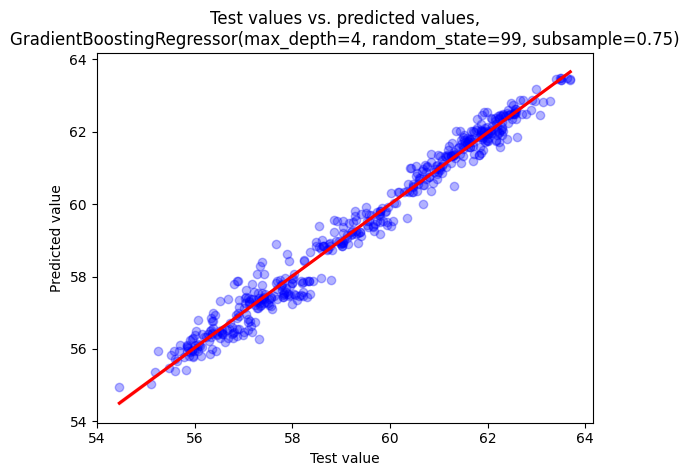

-----Test set statistics-----
R-squared of the model on the test set is: 0.9793165888249002
Mean absolute error of the prediction is: 0.24598886777026194
Mean squared error of the prediction is: 0.1077575800421359
Root mean squared error of the prediction is: 0.32826449707840155
Mean absolute percentage error of the prediction is: 0.41690215293681293


In [41]:
comp_train_test(gb_model,X_train,y_train,X_test,y_test)

## Best Performing Model

We will now compare our scores from cross validation.

In [42]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
kfold_df['avg_explained_variance'] = kfold_df.mean(axis=1)
kfold_df.sort_values(['avg_explained_variance'],ascending=False)
kfold_df.style.hide(axis="index")

<ipython-input-42-35c266843707>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kfold_df['avg_explained_variance'] = kfold_df.mean(axis=1)


Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_explained_variance
LinearRegression(),0.979002,0.980629,0.975730,0.977538,0.970114,0.976603
KNeighborsRegressor(n_neighbors=8),0.980938,0.983907,0.979045,0.981961,0.975714,0.980313
"RandomForestRegressor(n_estimators=10, n_jobs=-1)",0.977158,0.982333,0.979434,0.980091,0.975287,0.978861
SVR(),0.979650,0.981405,0.975992,0.978008,0.971531,0.977317
"GradientBoostingRegressor(max_depth=4, random_state=99, subsample=0.75)",0.978112,0.983274,0.980082,0.979451,0.976249,0.979434


In [43]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
kfold_mae_df['avg_neg_means_abs_error'] = kfold_mae_df.mean(axis=1)
kfold_mae_df.sort_values(['avg_neg_means_abs_error'],ascending=False)
kfold_mae_df.style.hide(axis="index")

<ipython-input-43-688d5ba27813>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kfold_mae_df['avg_neg_means_abs_error'] = kfold_mae_df.mean(axis=1)


Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_neg_means_abs_error
LinearRegression(),-0.268072,-0.258160,-0.291567,-0.290374,-0.316078,-0.284850
KNeighborsRegressor(n_neighbors=8),-0.251812,-0.225905,-0.261400,-0.244668,-0.264528,-0.249663
"RandomForestRegressor(n_estimators=10, n_jobs=-1)",-0.270106,-0.222550,-0.258322,-0.257194,-0.264300,-0.254494
SVR(),-0.261072,-0.248134,-0.281731,-0.286146,-0.307766,-0.276970
"GradientBoostingRegressor(max_depth=4, random_state=99, subsample=0.75)",-0.267282,-0.232334,-0.260764,-0.265421,-0.268238,-0.258808


From these statistics, the best performing model is the gradient boosting model with our optimized parameters. We can see that our improved model greatly enchances the predicted average temperature.

In [44]:
# MAE
print('Boost Train MAE (in degrees):', round(mean_absolute_error(y_train,gb_model.predict(X_train)),2))
print('Base Test MAE (in degrees):', round(mean_absolute_error(y_test,gb_model.predict(X_test)),2))

Boost Train MAE (in degrees): 0.19
Base Test MAE (in degrees): 0.25


Instead of being off by 2.03 degrees, our best performing model is accurate to around 0.25 degrees in the Test set. We also get good accuracy with the optimized gradient boosting model.

In [45]:
mape = mean_absolute_percentage_error(y_test, gb_model.predict(X_test)) * 100
accuracy = 100 - mape
print("Accuracy of Gradient Boosting Model:", round(accuracy,2), "%.")

Accuracy of Gradient Boosting Model: 99.58 %.


## Model Visualizations

We now show several Partial Dependence Plots (PDPs). The goal of PDPs are to visualize the effect one or two features have on the predicted outcome of a machine learning model. We will inspect our training features - `LandAverageTemperature`, `LandMaxTemperature`, and `LandMinTemperature` and see the effect these have on the machine learning model.

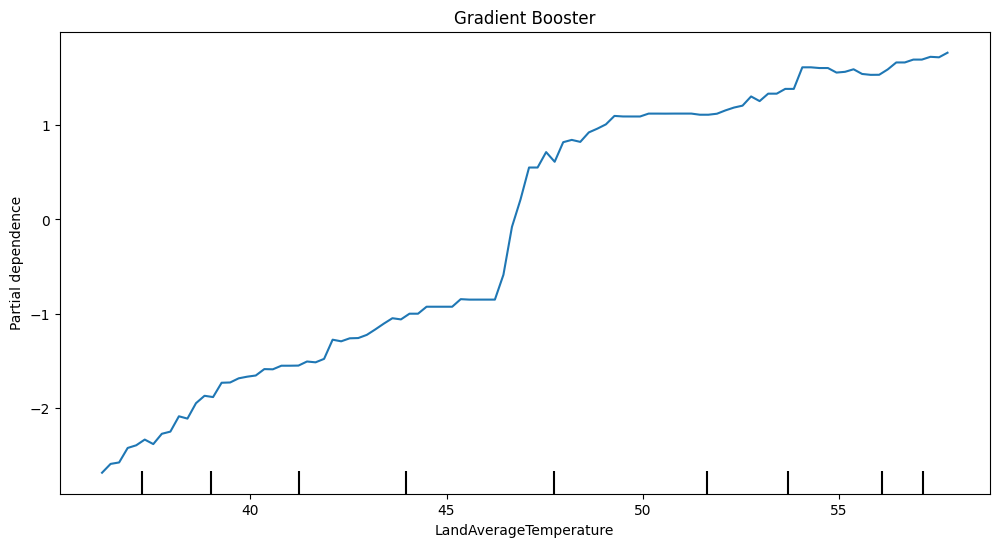

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Gradient Booster")
# The feature that we want to compare against our model to see the net effect on the model prediction (our target)
feature = ['LandAverageTemperature' ]
gb_disp = PartialDependenceDisplay.from_estimator(gb_model, X_test, feature, ax=ax)

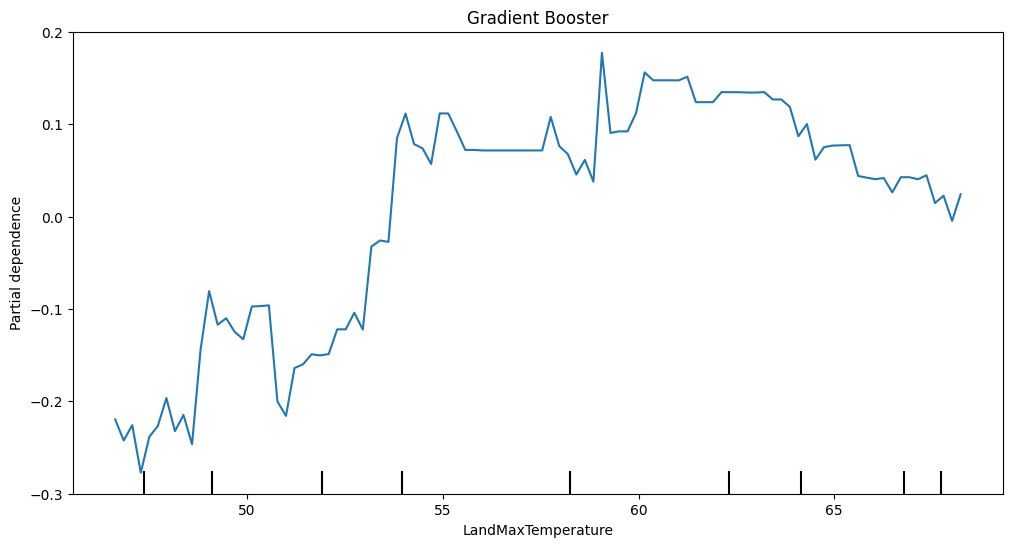

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Gradient Booster")
# The feature that we want to compare against our model to see the net effect on the model prediction (our target)
feature = ['LandMaxTemperature' ]
gb_disp = PartialDependenceDisplay.from_estimator(gb_model, X_test, feature, ax=ax)

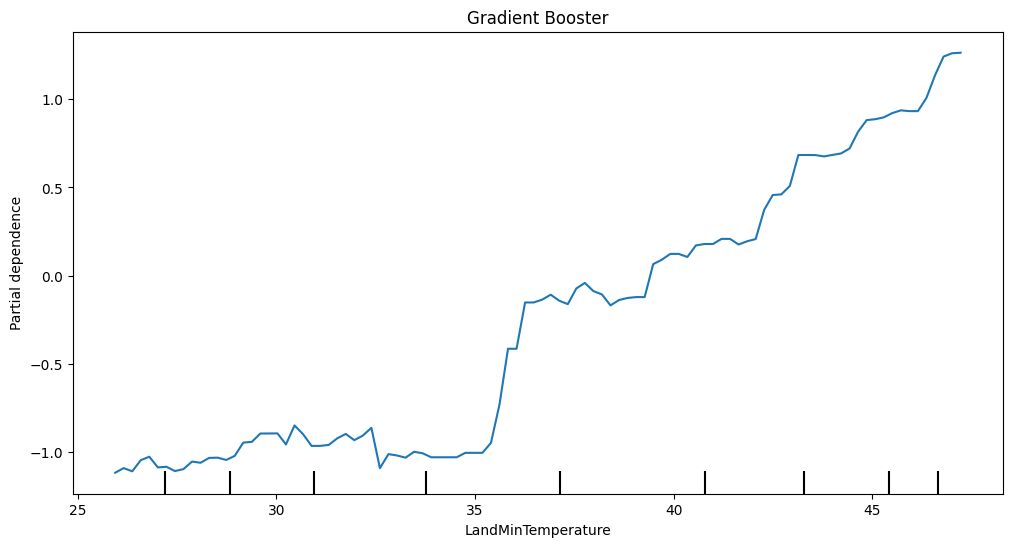

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Gradient Booster")
# The feature that we want to compare against our model to see the net effect on the model prediction (our target)
feature = ['LandMinTemperature' ]
gb_disp = PartialDependenceDisplay.from_estimator(gb_model, X_test, feature, ax=ax)

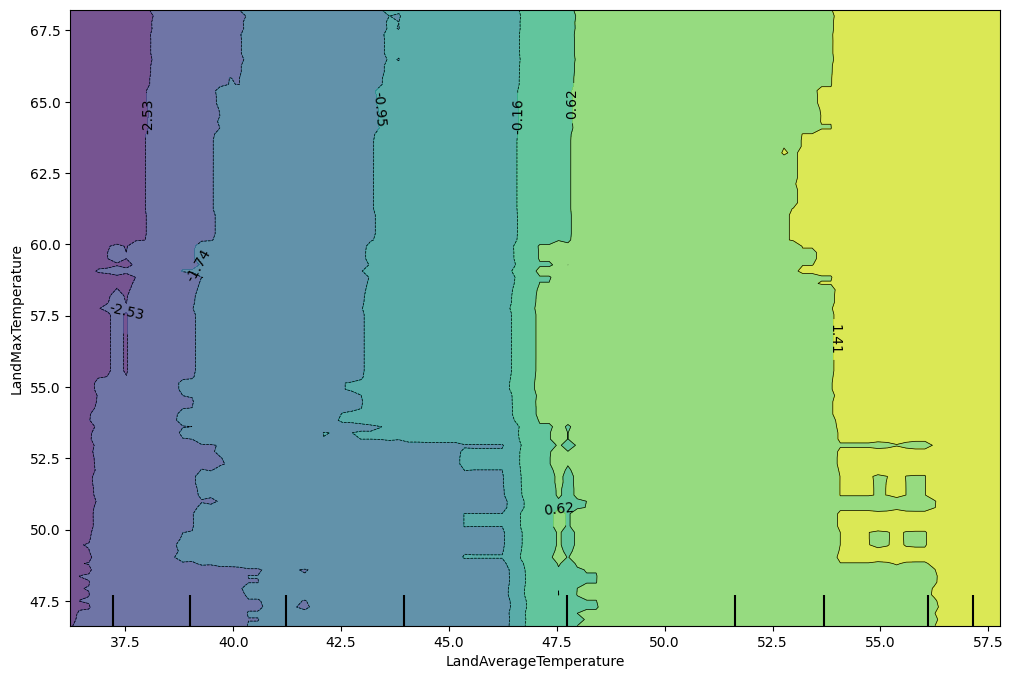

In [62]:
features = [('LandAverageTemperature','LandMaxTemperature')];
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(gb_model, X_test, features,ax=ax)
plt.show()

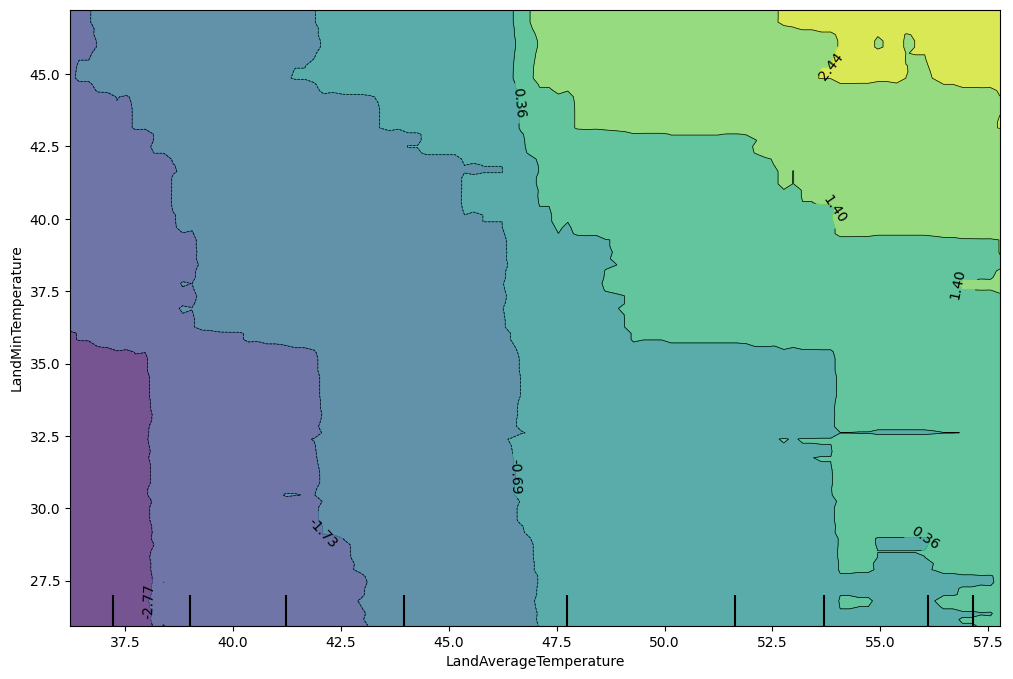

In [63]:
features = [('LandAverageTemperature','LandMinTemperature')];
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(gb_model, X_test, features,ax=ax)
plt.show()

## Discussion and recommendations

* RNN (LSTM)
* Other files